100%|██████████| 26.4M/26.4M [00:03<00:00, 8.52MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.98MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

LR: 0.001, Hidden Layers: 1, Hidden Units: 64, Test Accuracy: 87.22%
LR: 0.001, Hidden Layers: 1, Hidden Units: 128, Test Accuracy: 88.25%
LR: 0.001, Hidden Layers: 1, Hidden Units: 256, Test Accuracy: 87.32%
LR: 0.001, Hidden Layers: 2, Hidden Units: 64, Test Accuracy: 87.90%
LR: 0.001, Hidden Layers: 2, Hidden Units: 128, Test Accuracy: 88.10%
LR: 0.001, Hidden Layers: 2, Hidden Units: 256, Test Accuracy: 87.77%
LR: 0.001, Hidden Layers: 3, Hidden Units: 64, Test Accuracy: 87.22%
LR: 0.001, Hidden Layers: 3, Hidden Units: 128, Test Accuracy: 87.16%
LR: 0.001, Hidden Layers: 3, Hidden Units: 256, Test Accuracy: 88.45%
LR: 0.01, Hidden Layers: 1, Hidden Units: 64, Test Accuracy: 84.39%
LR: 0.01, Hidden Layers: 1, Hidden Units: 128, Test Accuracy: 85.32%
LR: 0.01, Hidden Layers: 1, Hidden Units: 256, Test Accuracy: 83.34%
LR: 0.01, Hidden Layers: 2, Hidden Units: 64, Test Accuracy: 83.56%
LR: 0.01, 

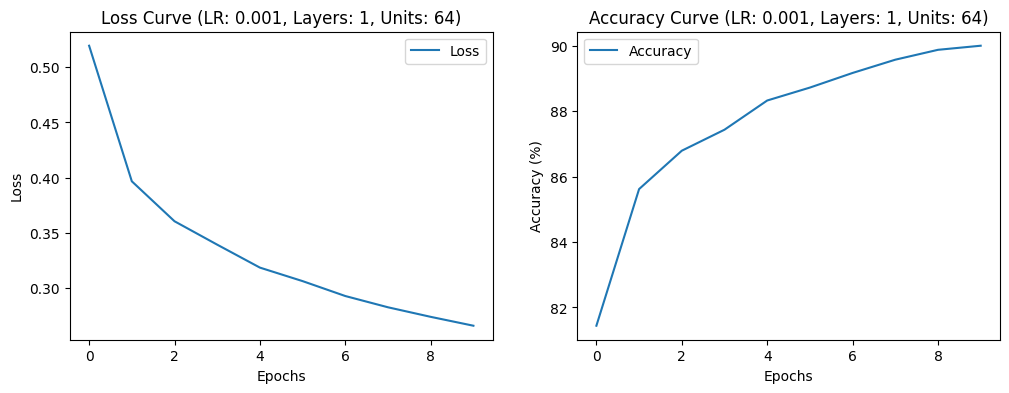

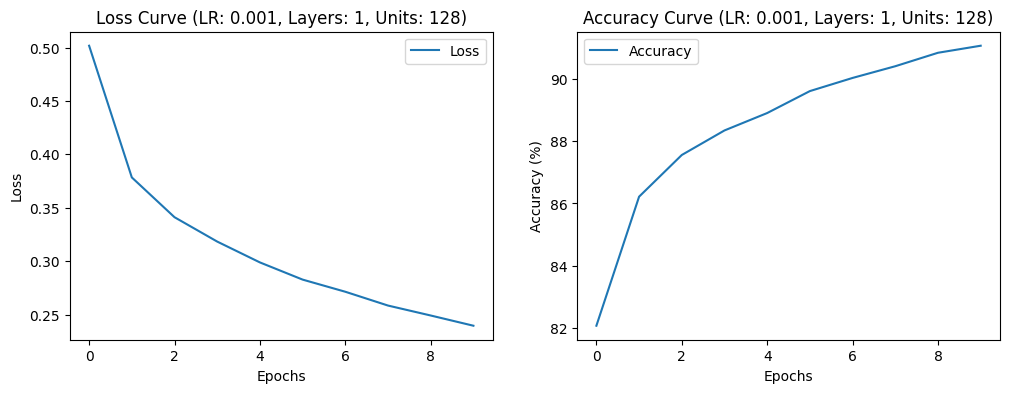

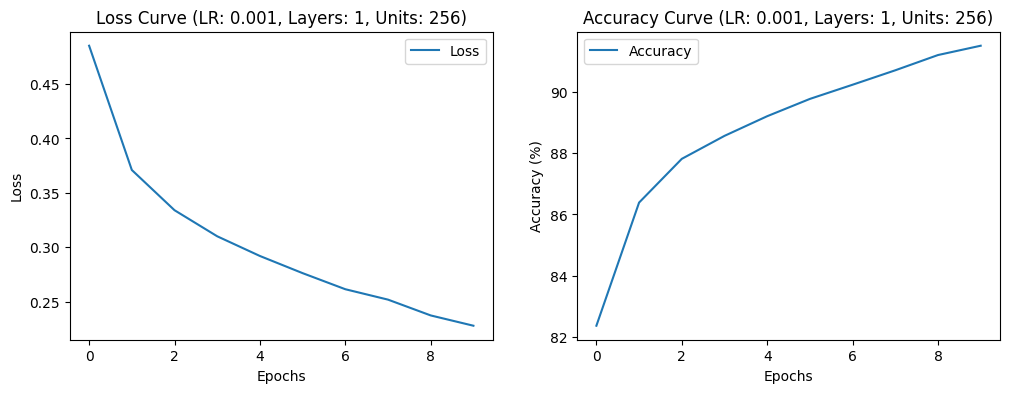

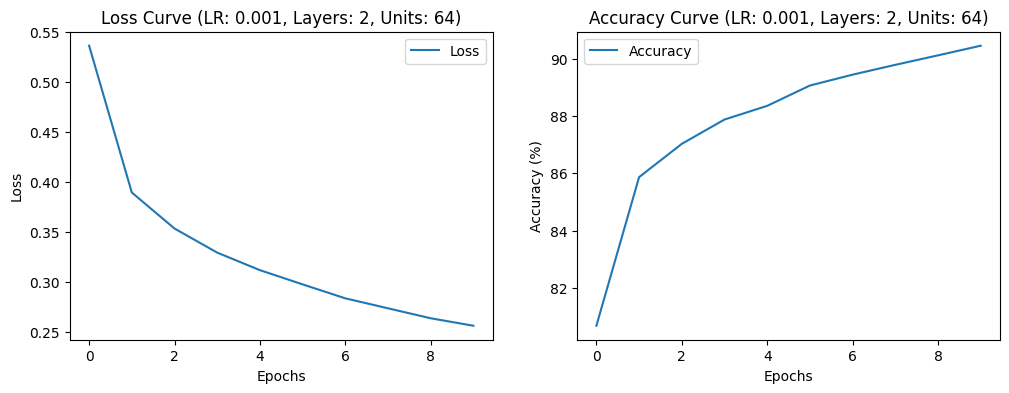

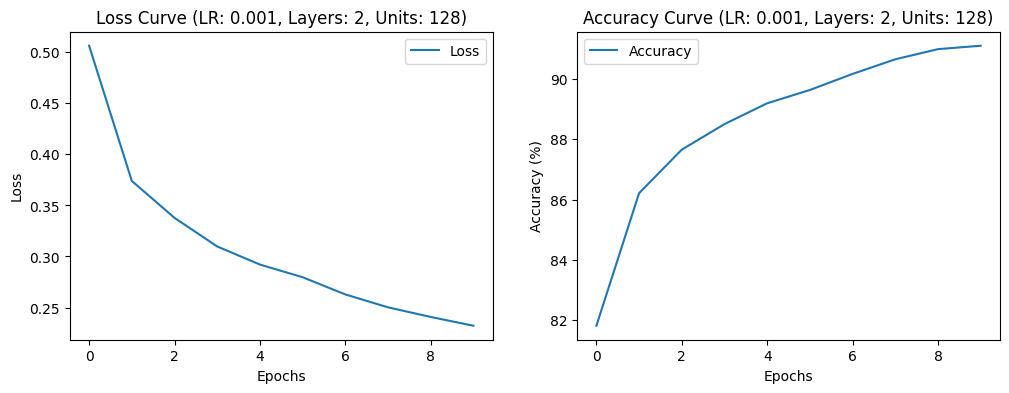

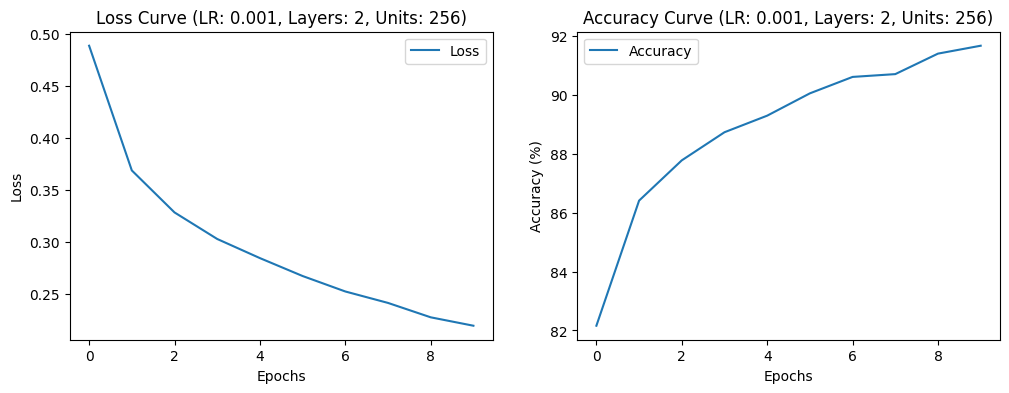

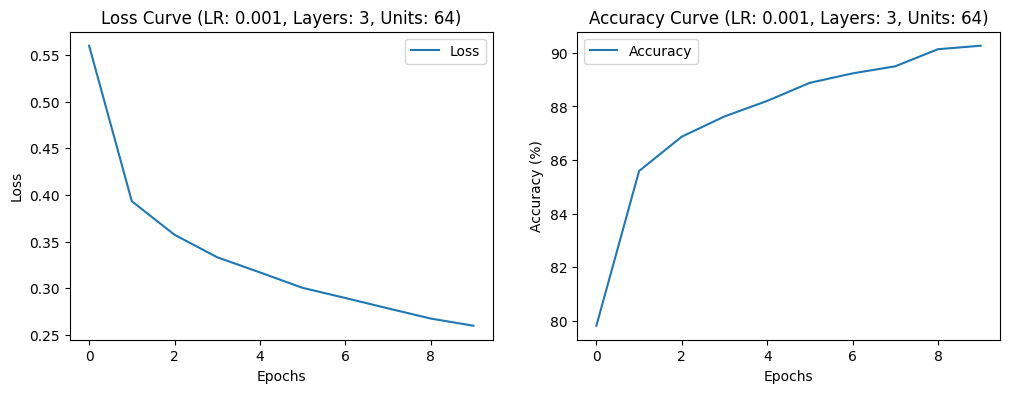

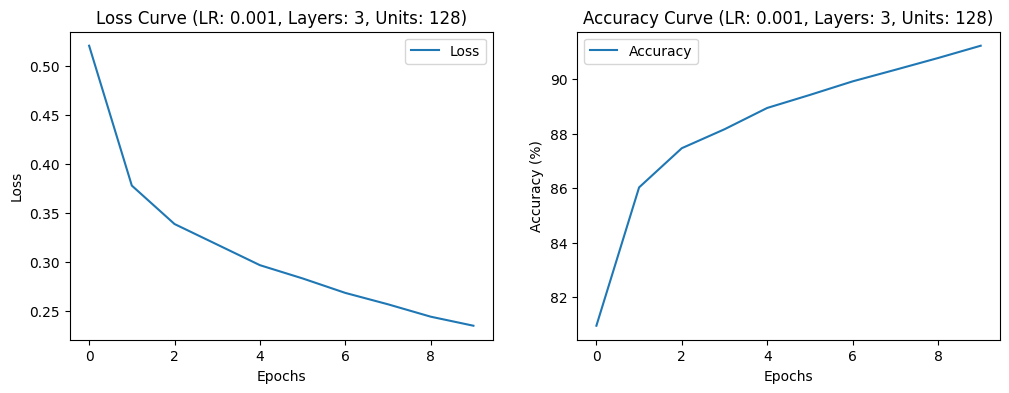

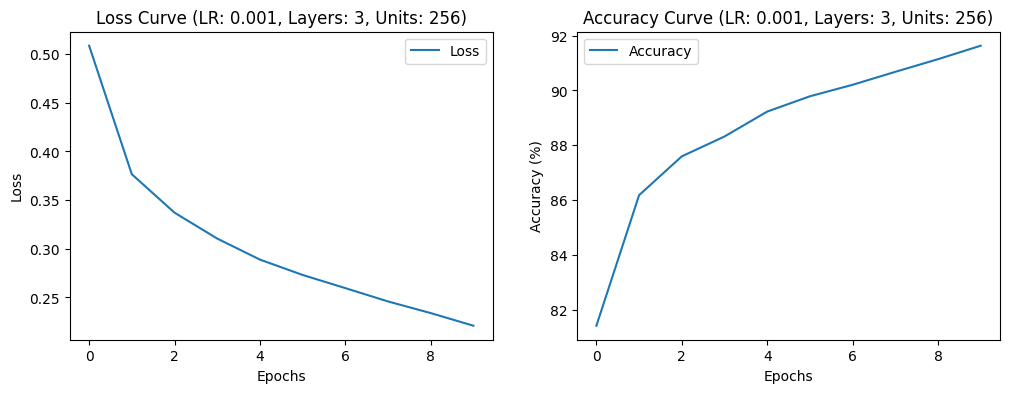

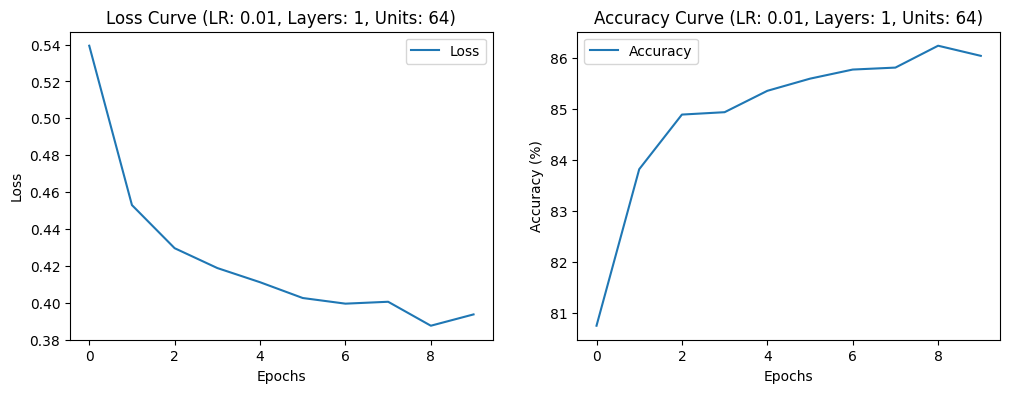

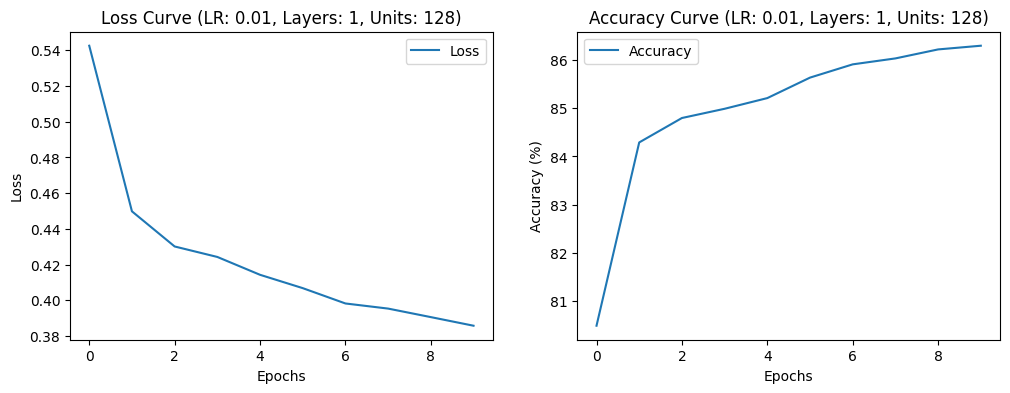

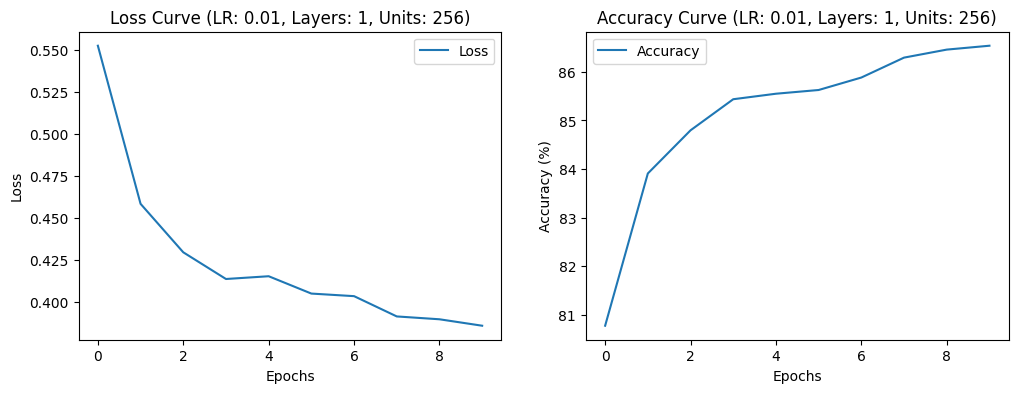

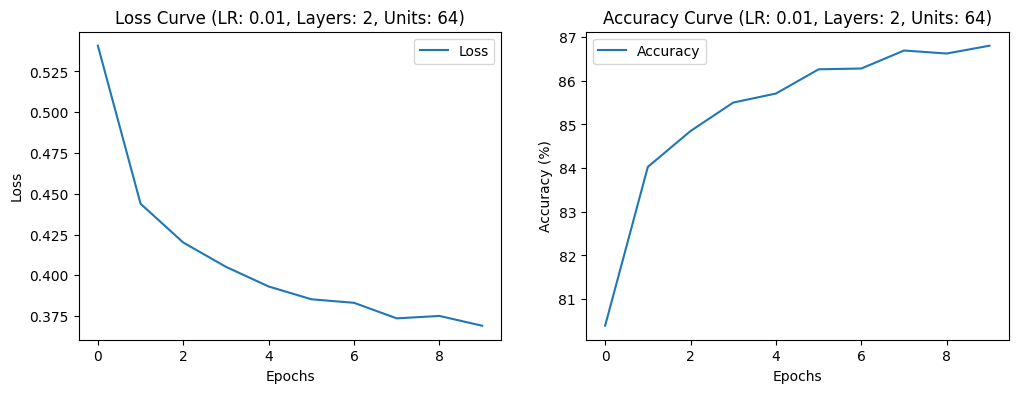

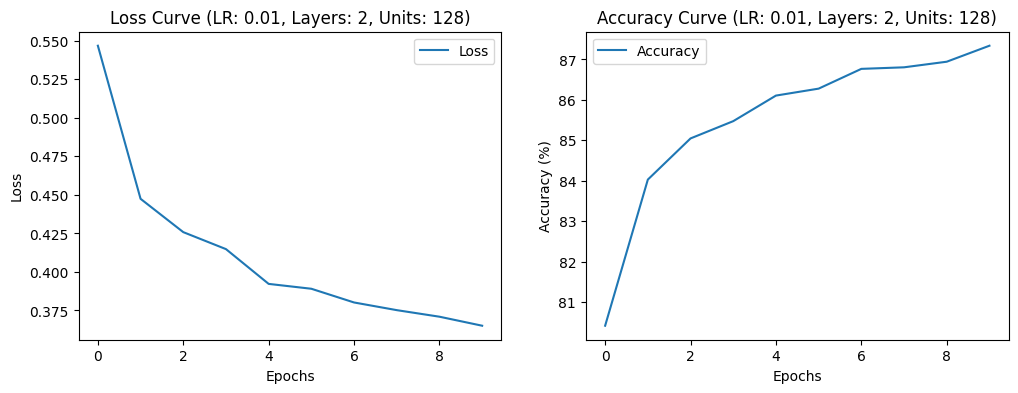

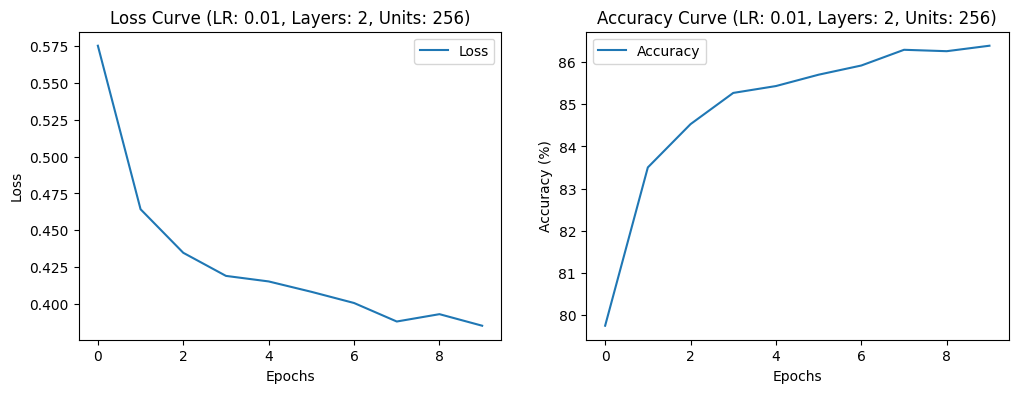

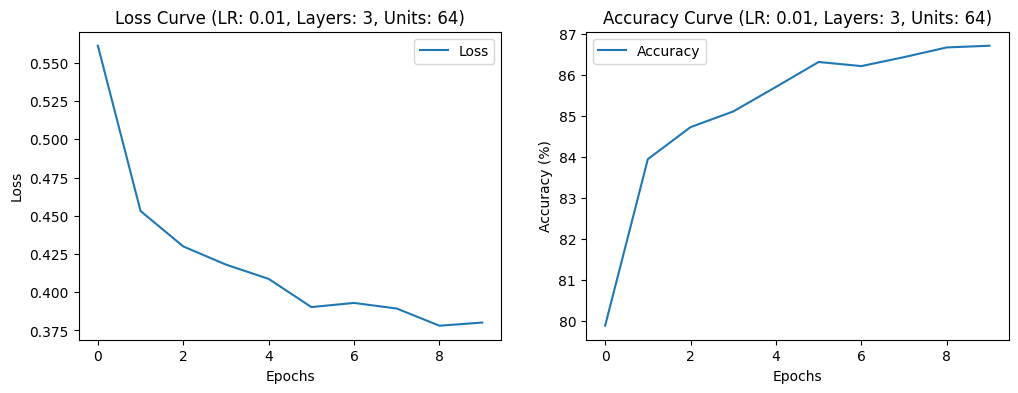

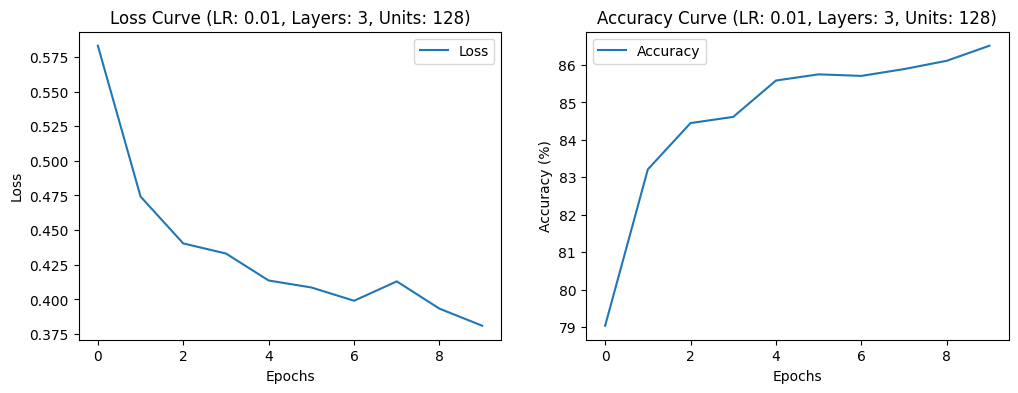

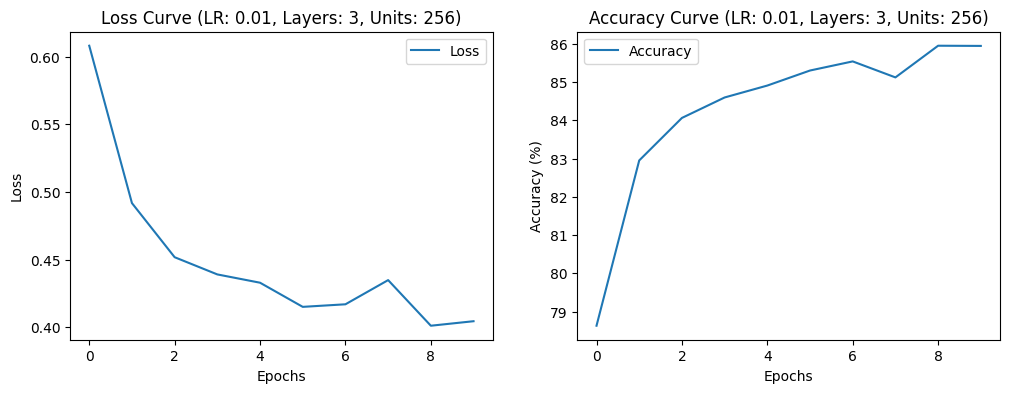

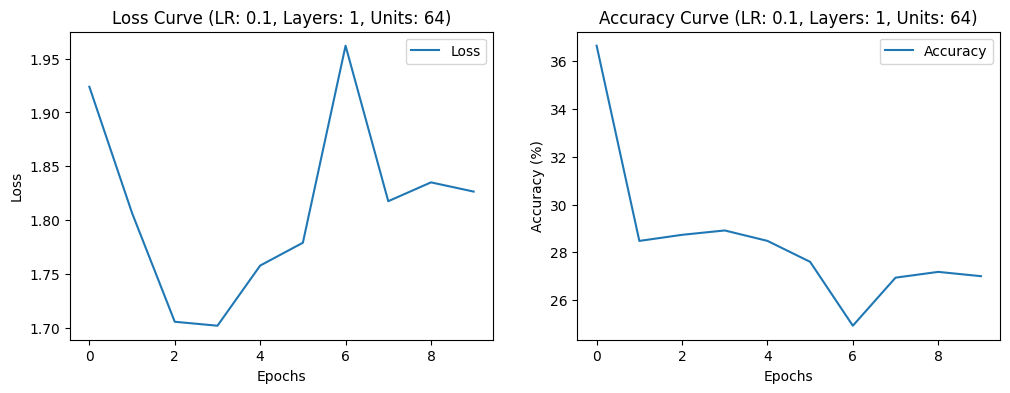

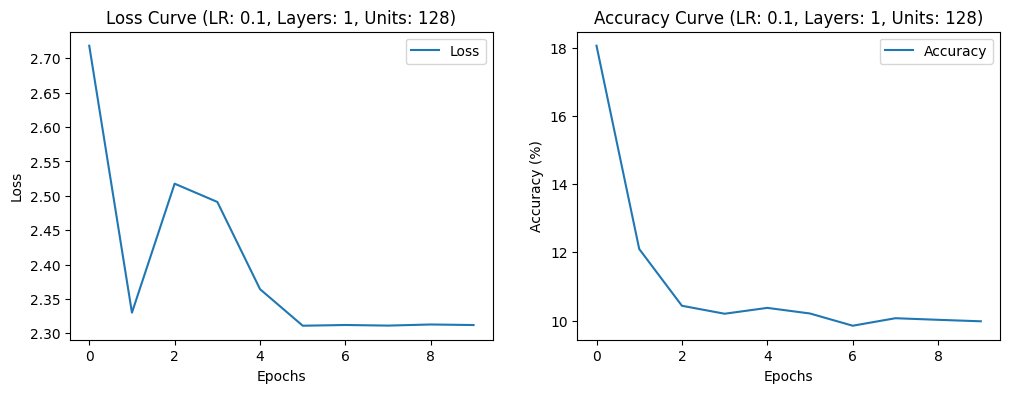

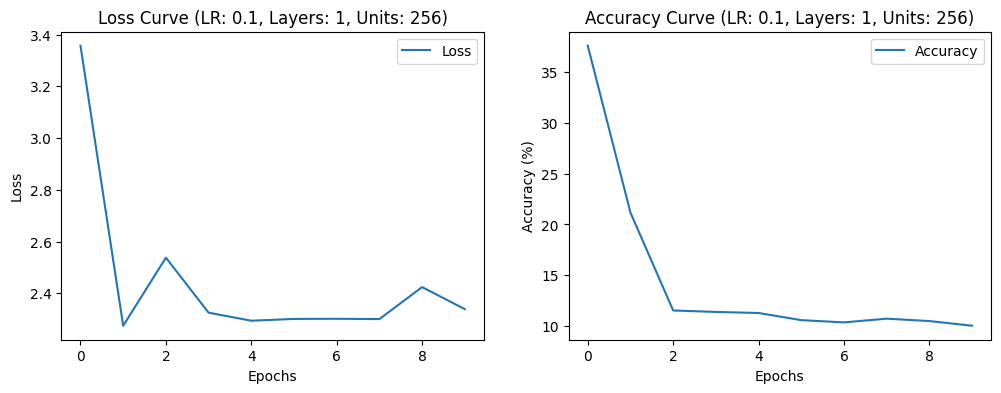

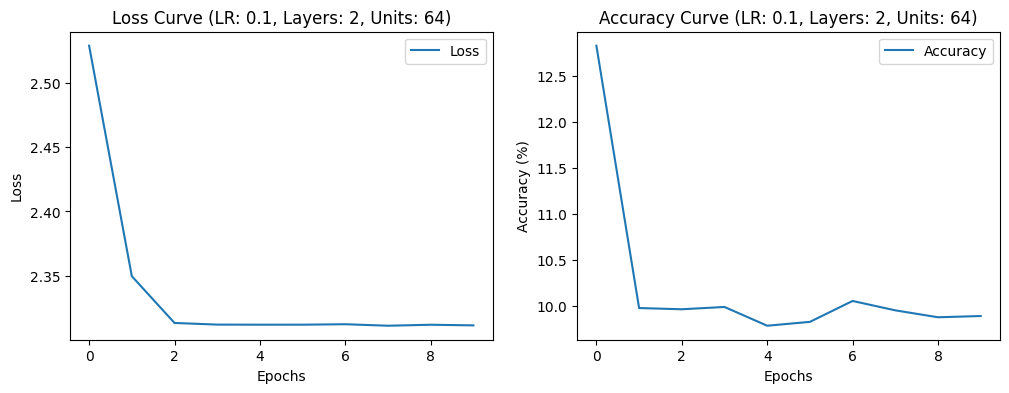

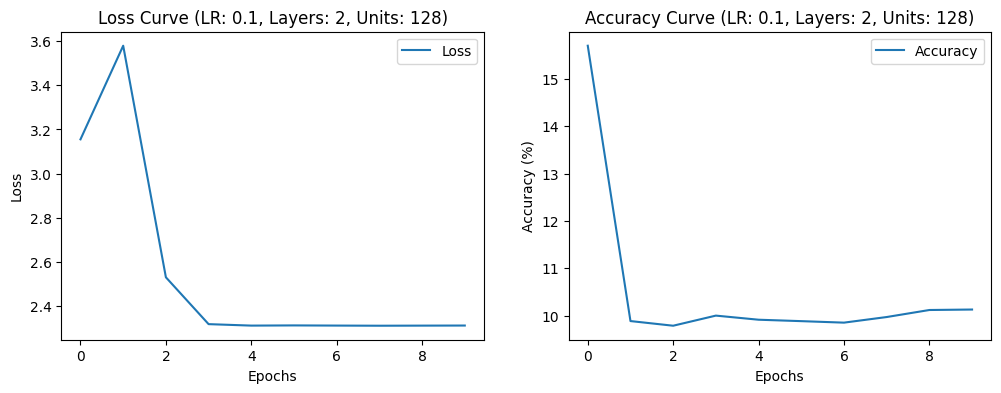

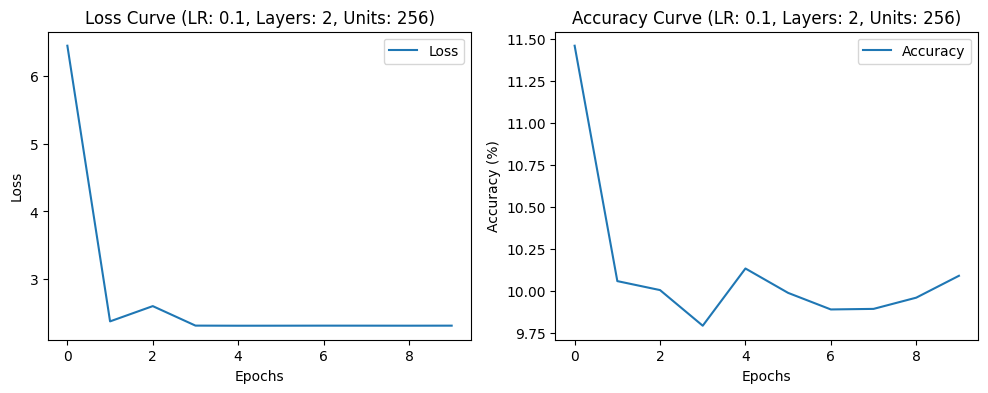

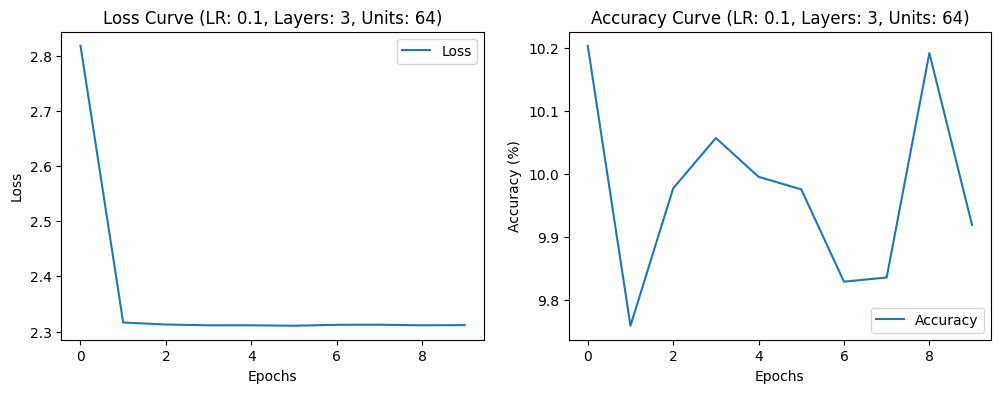

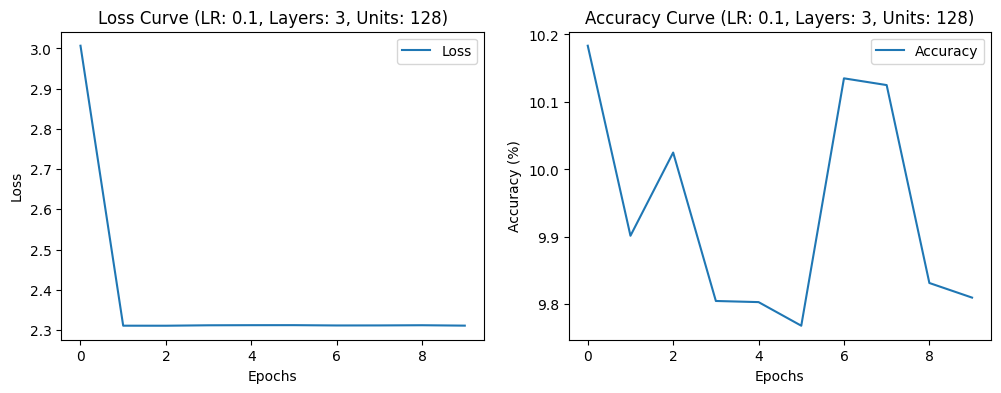

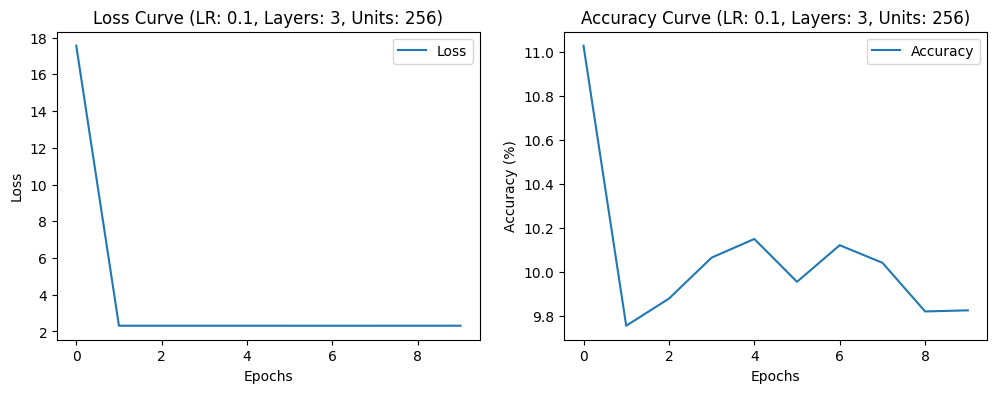

Best Configuration - Learning Rate: 0.001, Hidden Layers: 3, Hidden Units: 256


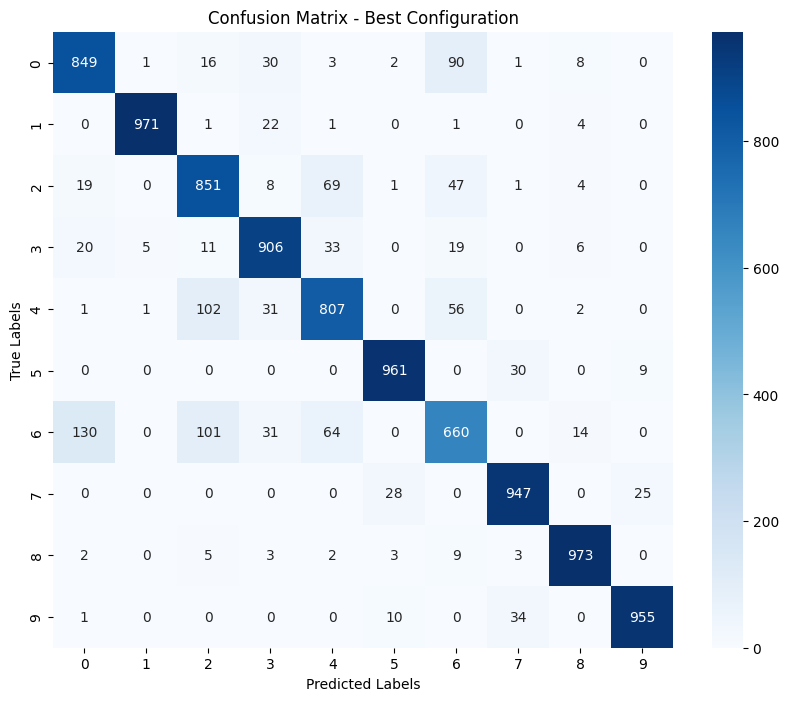

Class 0 is most commonly confused with class 6
Class 1 is most commonly confused with class 3
Class 2 is most commonly confused with class 4
Class 3 is most commonly confused with class 4
Class 4 is most commonly confused with class 2
Class 5 is most commonly confused with class 7
Class 6 is most commonly confused with class 0
Class 7 is most commonly confused with class 5
Class 8 is most commonly confused with class 6
Class 9 is most commonly confused with class 7


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, hidden_layers, hidden_units):
        super(MLP, self).__init__()
        layers = [nn.Linear(28*28, hidden_units), nn.ReLU()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_units, hidden_units), nn.ReLU()]
        layers.append(nn.Linear(hidden_units, 10))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.network(x)

def train_model(model, optimizer, criterion, num_epochs=10):
    model.train()
    loss_history, accuracy_history = [], []
    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        loss_history.append(running_loss / len(train_loader))
        accuracy_history.append(100 * correct / total)
    return loss_history, accuracy_history

def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    return 100 * correct / total, all_preds, all_labels

learning_rates = [0.001, 0.01, 0.1]
hidden_layers_list = [1, 2, 3]
hidden_units_list = [64, 128, 256]

results = {}
for lr in learning_rates:
    for hl in hidden_layers_list:
        for hu in hidden_units_list:
            model = MLP(hidden_layers=hl, hidden_units=hu)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            loss_history, accuracy_history = train_model(model, optimizer, criterion)
            test_accuracy, _, _ = evaluate_model(model)
            results[(lr, hl, hu)] = (loss_history, accuracy_history, test_accuracy)
            print(f"LR: {lr}, Hidden Layers: {hl}, Hidden Units: {hu}, Test Accuracy: {test_accuracy:.2f}%")

for (lr, hl, hu), (loss_history, accuracy_history, test_accuracy) in results.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label="Loss")
    plt.title(f"Loss Curve (LR: {lr}, Layers: {hl}, Units: {hu})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label="Accuracy")
    plt.title(f"Accuracy Curve (LR: {lr}, Layers: {hl}, Units: {hu})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

best_config = max(results.items(), key=lambda x: x[1][2])[0]
print(f"Best Configuration - Learning Rate: {best_config[0]}, Hidden Layers: {best_config[1]}, Hidden Units: {best_config[2]}")

best_model = MLP(hidden_layers=best_config[1], hidden_units=best_config[2])
optimizer = optim.Adam(best_model.parameters(), lr=best_config[0])
train_model(best_model, optimizer, nn.CrossEntropyLoss())
_, all_preds, all_labels = evaluate_model(best_model)

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best Configuration')
plt.show()

most_confused_with = {}
for i in range(10):
    row = conf_mat[i, :]
    row[i] = 0
    most_confused_class = np.argmax(row)
    most_confused_with[i] = most_confused_class
    print(f"Class {i} is most commonly confused with class {most_confused_class}")